In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
def choose_top_rw(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.Rw, method='first')<=n)
def choose_top_vtotal(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.VTotal, method='first')<=n)
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)

In [122]:
protein_list = ["T0949", "T0950"]
name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
all_data_list = []
for protein in protein_list:
    for i in range(1,4):
        awsem = pd.read_table(f"/Users/weilu/Research/server/casp13/result/{protein}/post-processing/model.{i}/awsem_energy/awsem.log", names=name_list)
        rw = pd.read_table(f"/Users/weilu/Research/server/casp13/result/{protein}/post-processing/model.{i}/lowTstructure/rwplusScore.short.txt", names=["i", "Rw"], sep="\s+")
        rw = rw.reset_index(drop=True)
        awsem = awsem.reset_index().drop("Step", axis=1).rename(columns={"index":"Step"}).assign(model=i)
        data = pd.concat([rw, awsem], axis=1)
        remove_columns = ['i', "Shake", "Excluded", "Membrane", "Vec_FM", "SSB", "Electro."]
        all_data_list.append(data.drop(remove_columns, axis=1).assign(Name=protein))
data = pd.concat(all_data_list)

In [32]:
# rw = pd.read_table(f"/Users/weilu/Research/server/casp13/result/T0949/post-processing/model.1/lowTstructure/rwplusScore.short.txt", names=["i", "Rw"], sep="\s+")

In [ ]:
# # protein_list = ["T0766", "1MBA", "T0784", "T0792", "T0803", "T0815", "T0833", "T0251"]
# protein_list = ["T0949"]
# name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
# all_data_list = []

# for protein in protein_list:
#     awsem = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_awsem.log", names=name_list)
#     rw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_rw.txt", names=["i", "Rw"], sep="\s+")
#     rmsd = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_rmsd.txt", names=["i2", "Rmsd"], sep="\s+")
#     qw = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_qw.txt", names=["i3", "Qw"], sep="\s+")
#     gdt = pd.read_table(f"/Users/weilu/Research/davinci/structure_selector_mar21/{protein}_GDT.txt", names=["gdt"+str(i) for i in range(1,21)], sep="\s+")
#     rw = rw.reset_index(drop=True)
#     awsem = awsem.reset_index(drop=True)
#     rmsd = rmsd.reset_index(drop=True)
#     qw = qw.reset_index(drop=True)
#     gdt["GDT"] = (gdt["gdt2"] + gdt["gdt4"] + gdt["gdt8"] + gdt["gdt16"])*25
#     gdt = gdt.reset_index(drop=True)
#     data = pd.concat([rw, qw, rmsd, gdt["GDT"], awsem], axis=1)
# #     print(data)
#     remove_columns = ['i', 'i2', 'i3', 'Step', "Shake", "Excluded", "AMH_Go", "Membrane", "Vec_FM", "SSB", "Electro."]
# #     if protein == "T0251":
# #         p = "T251"
# #     elif protein == "1mba":
# #         p = "1MBA"
# #     else:
# #         p = protein
#     p = protein
#     data = data.drop(remove_columns, axis=1).reset_index().assign(Name=p)
#     all_data_list.append(data)
# all_data = pd.concat(all_data_list).reset_index(drop=True)


In [4]:
FEATURES = ['Rw',
#      'VTotal',
#      'QGO',
#      'VwithoutGo',
     'Burial',
     'Water',
     'Rama',
#      'DSSP',
#      'P_AP',
     'Helix',
#      'Frag_Mem'
               ]
n = 5
def my_transform(data, label, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

def my_transform_predict(data, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    PolynomialDegree = degree

    num_attribs = FEATURES
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    return num_pipeline.fit_transform(data)

In [5]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/complete_data_mar27.csv", index_col=0)
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
# raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
# raw_data = raw_data_T0792
# raw_data = raw_test_data.groupby("Name").get_group("1mba")
raw_data = raw_data_T0784

In [6]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
def train_and_test(raw_data, label="Qw", degree=1, p=0.1):
    # my_full_pipeline = Pipeline([
    # #         ('removeFirstFrame', RemoveFirstFrame(frame)),
    #         ('featureSelection', full_pipeline)
    # ])

    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=142)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_transform(strat_train_set, label, degree)
    X_test = my_transform(strat_test_set, label, degree)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]
    return (train_set, train_y, test_set, test_y)

In [123]:
prediction_list = []
for name, data in data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
#     X = my_transform(data, label, degree)
#     eval_y = X[:,-1]
#     eval_set = X[:,:-1]
    X = my_transform_predict(data, degree)
    eval_set = X
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=10, col="prediction").query("chosen==True")

T0949
T0950


In [127]:
t.rename(columns={"prediction":"score"}).\
    to_csv("/Users/weilu/Dropbox/IAAWSEM/casp13/selection/all_atom_refinement_energy_rw_and_score_by_ml.csv")

In [119]:
best_by_prediction

Rw  Step      Chain       Chi        Rama  DSSP  P_AP  \
Name                                                                        
T0950 0  -61009.910311     0  19.974224  0.564958 -831.822916   0.0   0.0   
      31 -61009.910311    31  19.974224  0.564958 -831.822916   0.0   0.0   
      32 -57593.280937    32  19.974224  0.564958 -831.822916   0.0   0.0   
      61 -61009.910311    61  19.974224  0.564958 -831.822916   0.0   0.0   
      0  -60828.007092     0  19.974224  0.564958 -831.822916   0.0   0.0   
      31 -60828.007092    31  19.974224  0.564958 -831.822916   0.0   0.0   
      61 -60828.007092    61  19.974224  0.564958 -831.822916   0.0   0.0   
      0  -59436.402108     0  19.974224  0.564958 -831.822916   0.0   0.0   
      25 -59436.402108    25  19.974224  0.564958 -831.822916   0.0   0.0   
      50 -59436.402108    50  19.974224  0.564958 -831.822916   0.0   0.0   

          Water      Burial  Helix  AMH_Go     Frag_Mem         QGO  \
Name                                                                  
T0950 0     0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      31    0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      32    0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      61    0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      0     0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      31    0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      61    0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      0     0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      25    0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   
      50    0.0 -266.195885    0.0     0.0 -1825.023248  198.979812   

               VTotal  model   Name  prediction  chosen  
Name                                                     
T0950 0  -2703.523056      1  T0950    0.177612    True  
      31 -2703.523056      1  T0950    0.177612    True  
      32 -2703.523056      1  T0950    0.047315    True  
      61 -2703.523056      1  T0950    0.177612    True  
      0  -2703.523056      2  T0950    0.166468    True  
      31 -2703.523056      2  T0950    0.166468    True  
      61 -2703.523056      2  T0950    0.166468    True  
      0  -2703.523056      3  T0950    0.098897    True  
      25 -2703.523056      3  T0950    0.098897    True  
      50 -2703.523056      3  T0950    0.098897    True

In [136]:
for name, one in best_by_prediction.reset_index(drop=True).groupby("Name"):
    print(name)
#     print(a.sort_values("prediction", ascending=False).reset_index())
    for i,a in one.sort_values("prediction", ascending=False).reset_index().iterrows():
        print(name, "model", a["model"], "Step", a["Step"])
        from_loc = f"/Users/weilu/Research/server/casp13/result/{name}/post-processing/model.{a['model']}/lowTstructure/lowTstructure{a['Step']}.pdb"
        to_loc = f"/Users/weilu/Dropbox/IAAWSEM/casp13/selection/selected/{name}_chosen_{i}.pdb"
#         os.system("cp "+from_loc+" "+to_loc)

T0949
T0949 model 2 Step 0
T0949 model 2 Step 32
T0949 model 2 Step 64
T0949 model 1 Step 0
T0949 model 1 Step 51
T0949 model 1 Step 102
T0949 model 2 Step 82
T0949 model 2 Step 90
T0949 model 2 Step 81
T0949 model 2 Step 89
T0950
T0950 model 1 Step 0
T0950 model 1 Step 31
T0950 model 1 Step 61
T0950 model 2 Step 0
T0950 model 2 Step 31
T0950 model 2 Step 61
T0950 model 3 Step 0
T0950 model 3 Step 25
T0950 model 3 Step 50
T0950 model 1 Step 32


In [ ]:
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)

In [52]:
chosen = one.assign(chosen=pd.DataFrame.rank(one["prediction"], ascending=False, method='first')<=5).query("chosen==True")

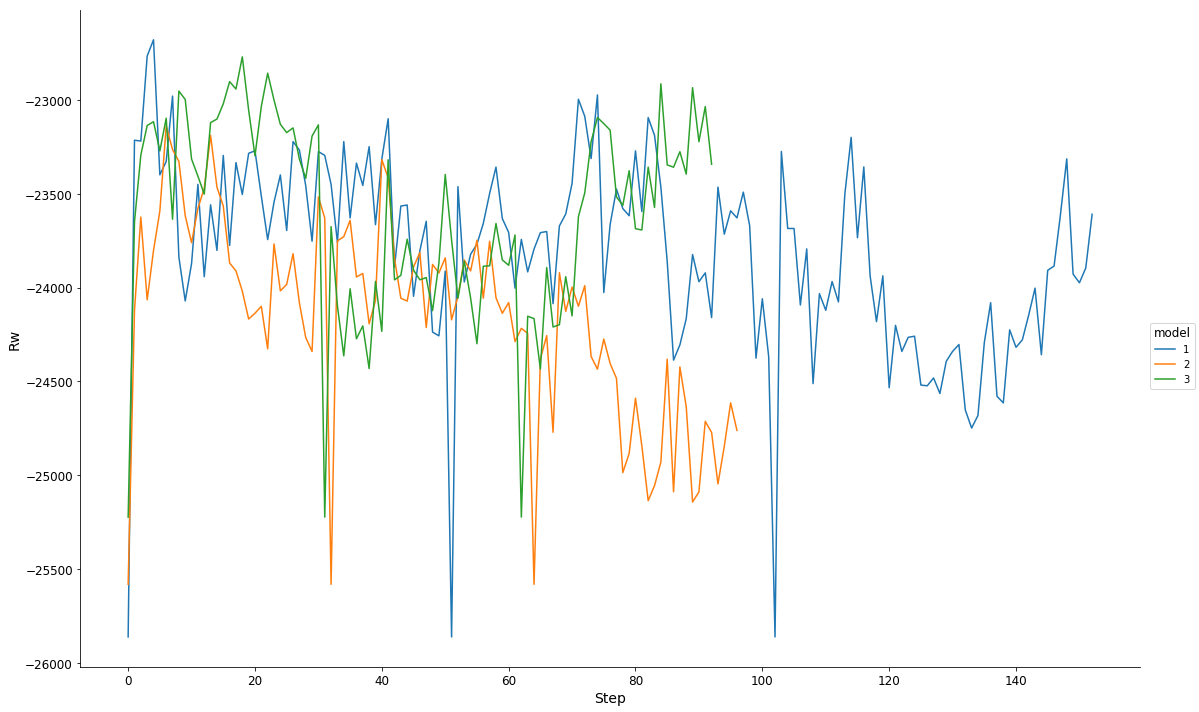

In [108]:
import seaborn
fg = seaborn.FacetGrid(data=data, hue='model',  aspect=1.61, size=10)
fg.map(plt.plot, 'Step', 'Rw').add_legend()

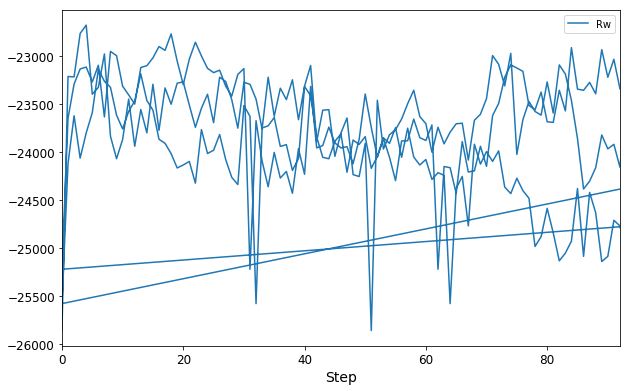

In [107]:
data.plot("Step", "Rw")

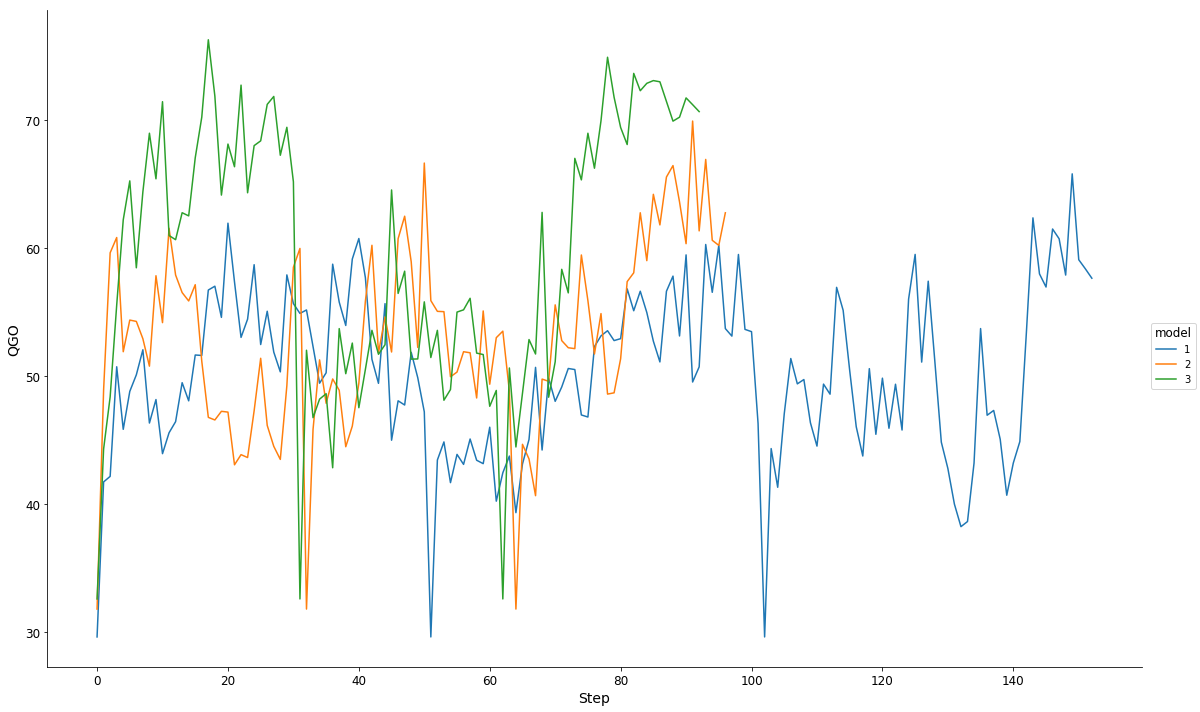

In [104]:
import seaborn
fg = seaborn.FacetGrid(data=data, hue='model',  aspect=1.61, size=10)
fg.map(plt.plot, 'Step', 'QGO').add_legend()

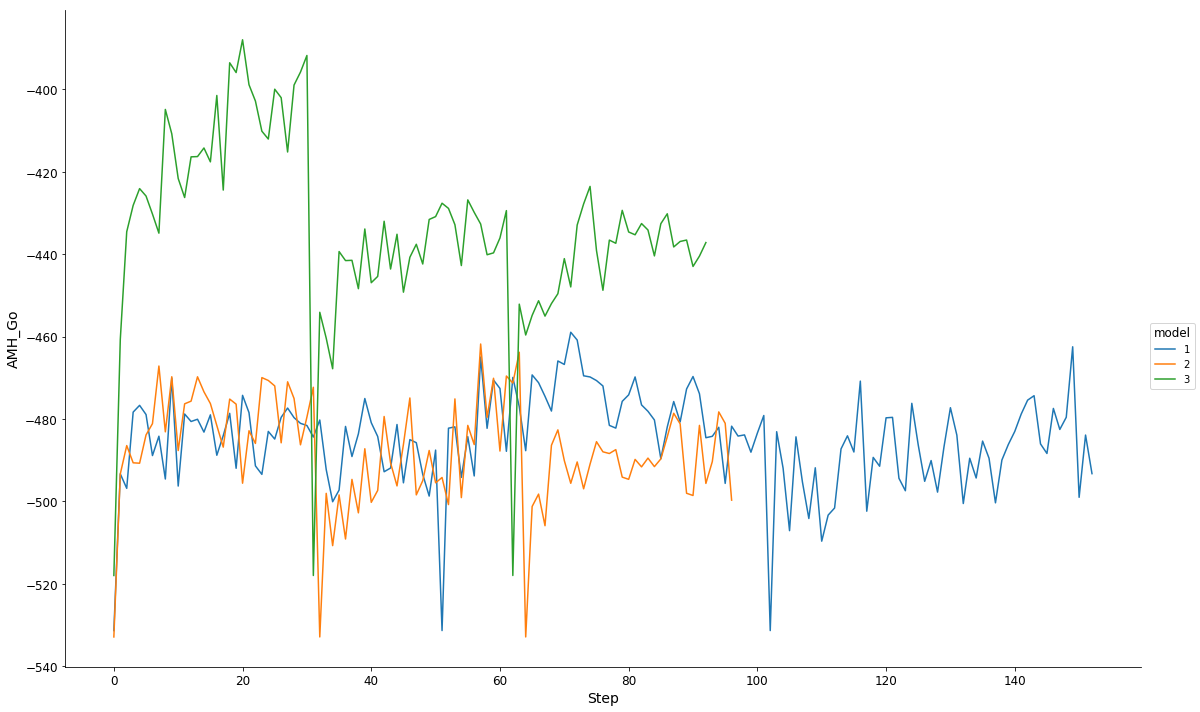

In [103]:
import seaborn
fg = seaborn.FacetGrid(data=data, hue='model',  aspect=1.61, size=10)
fg.map(plt.plot, 'Step', 'AMH_Go').add_legend()

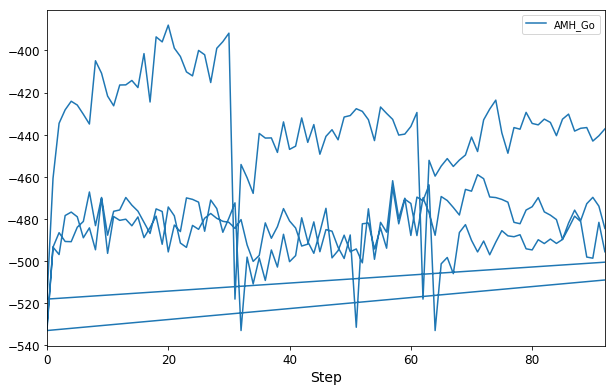

In [95]:
data.plot("Step", "AMH_Go", by="model")

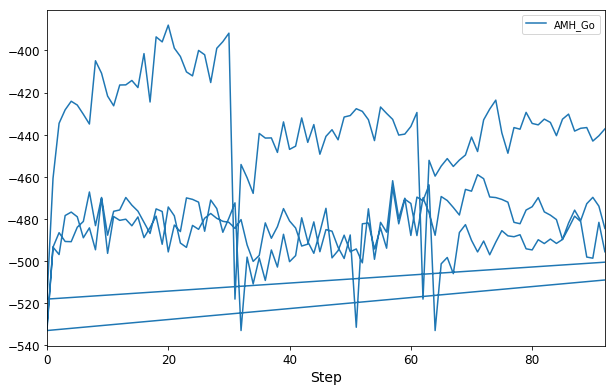

In [93]:
data.plot("Step", "AMH_Go", c="model")

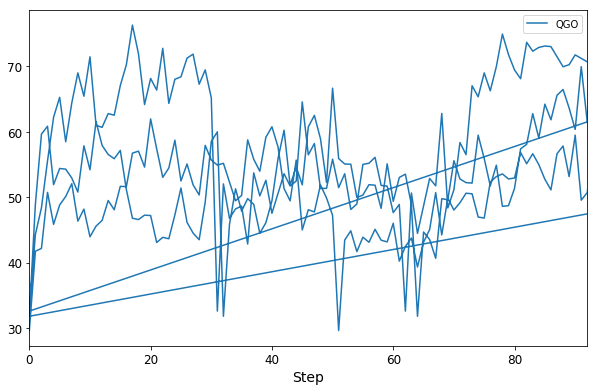

In [87]:
one.plot("Step", "QGO")

In [85]:
chosen = choose_top(one, col="prediction", n=10, ascending=False)\
        .query("chosen==True").sort_values("prediction", ascending=False).reset_index()
for i,a in chosen.reset_index().iterrows():
    print(a["Step"], a["model"])
    from_loc = f"/Users/weilu/Research/server/casp13/result/T0949/post-processing/model.{a['model']}/lowTstructure/lowTstructure{a['Step']}.pdb"
    to_loc = f"/Users/weilu/Research/data/casp13/T0494/chosen_{i}.pdb"
    os.system("cp "+from_loc+" "+to_loc)

0 2
32 2
64 2
0 1
51 1
102 1
82 2
90 2
81 2
89 2


In [42]:
one.apply(choose_top, n=5, col="prediction").query("chosen==True")

AttributeError: ("'Series' object has no attribute 'assign'", 'occurred at index Rw')

In [13]:
label = "isGood"
degree = 1
p = 0.1
train_set, train_y, test_set, test_y = train_and_test(raw_data, label=label, degree=degree)
log_clf = LogisticRegression(random_state=140, penalty='l2')

# log_clf = LogisticRegression(random_state=14, class_weight={0:p, 1:(1-p)}, penalty='l1')
log_clf.fit(train_set, train_y)
# y_pred = log_clf.predict(train_set)
# n = 100
prediction_list = []
for name, data in raw_test_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
#     X = my_transform(data, label, degree)
#     eval_y = X[:,-1]
#     eval_set = X[:,:-1]
    X = my_transform_predict(data, degree)
    eval_set = X
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=5, col="prediction").query("chosen==True")

1MBA
T0251
T0766
T0784
T0792
T0803
T0815
T0833


In [14]:
best_by_prediction.columns

Index(['Burial', 'Chain', 'Chi', 'DSSP', 'Frag_Mem', 'GDT', 'Helix', 'Name',
       'P_AP', 'QGO', 'Qw', 'Rama', 'Rmsd', 'Rw', 'Step', 'VTotal',
       'VwithoutGo', 'Water', 'isGood', 'prediction', 'chosen'],
      dtype='object')

In [15]:
n = 5
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")

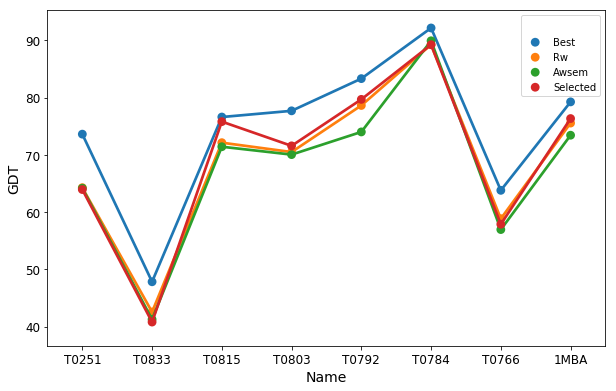

In [16]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=False).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/fig6_GDT.png", dpi=300)
# plt.ylim([0.4,1])
final_gdt = final3